In [1]:
# python
import numpy as np
import matplotlib.pyplot as plt
from typing import Any, List, Dict, Optional
import time

# pytorch:
import torch as t
import torchvision.transforms as ttf
from torch.optim import Adam
from torch.nn import (
    Sequential,
    Conv2d,
    BatchNorm2d,
    ReLU,
    MaxPool2d,
    Dropout,
    Flatten,
    Linear,
    Module,
    CrossEntropyLoss,
    Dropout2d
)

from torch.nn.functional import (
    nll_loss
)

# Custom lib:
import jx_pytorch_lib as jp
import jx_lib


## E3 - Q1: NN on MNIST > 90%
- We use VGG-11 architecture from last assignment for the MNIST data, see layer details below:
- The Final Accuracy is 98.94% for training and 98.4% for testing dataset

In [2]:
# USER DEFINE: ----- ----- ----- ----- ----- ----- ----- ----- ----- #
TOTA_NUM_EPOCHS = 5
LEARNING_RATE   = 0.001
BATCH_SIZE      = 100
MAX_SAMPLES     = None # Default: None => all data
# const:
OUT_DIR_E3      = "output/E3"
IMG_SIZE        = (32, 32)
VERBOSE_LEVEL   = jp.VerboseLevel.HIGH
DATA_AUG        = None #["HFlip", "VFlip", "GAUSS-0p5-0p5"]

# INIT: ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- #
### Directory generation ###
jp.create_all_folders(DIR=OUT_DIR_E3)

### MODEL ###
MODEL_DICT = {
    "VGG11": 
        Sequential(
            ## CNN Feature Extraction
            Conv2d(  1,  64, 3, 1, 1), BatchNorm2d( 64), ReLU(), MaxPool2d(2,2),
            Conv2d( 64, 128, 3, 1, 1), BatchNorm2d(128), ReLU(), MaxPool2d(2,2),
            Conv2d(128, 256, 3, 1, 1), BatchNorm2d(256), ReLU(),
            Conv2d(256, 256, 3, 1, 1), BatchNorm2d(256), ReLU(), MaxPool2d(2,2),
            Conv2d(256, 512, 3, 1, 1), BatchNorm2d(512), ReLU(),
            Conv2d(512, 512, 3, 1, 1), BatchNorm2d(512), ReLU(), MaxPool2d(2,2),
            Conv2d(512, 512, 3, 1, 1), BatchNorm2d(512), ReLU(),
            Conv2d(512, 512, 3, 1, 1), BatchNorm2d(512), ReLU(), MaxPool2d(2,2),
            # Classifier
            Flatten(1),
            Linear( 512, 4096), ReLU(), Dropout(0.5),
            Linear(4096, 4096), ReLU(), Dropout(0.5),
            Linear(4096,   10),
        ),
    "VGG11-FGSM": 
        Sequential(
            ## CNN Feature Extraction
            Conv2d(  1,  64, 3, 1, 1), BatchNorm2d( 64), ReLU(), MaxPool2d(2,2),
            Conv2d( 64, 128, 3, 1, 1), BatchNorm2d(128), ReLU(), MaxPool2d(2,2),
            Conv2d(128, 256, 3, 1, 1), BatchNorm2d(256), ReLU(),
            Conv2d(256, 256, 3, 1, 1), BatchNorm2d(256), ReLU(), MaxPool2d(2,2),
            Conv2d(256, 512, 3, 1, 1), BatchNorm2d(512), ReLU(),
            Conv2d(512, 512, 3, 1, 1), BatchNorm2d(512), ReLU(), MaxPool2d(2,2),
            Conv2d(512, 512, 3, 1, 1), BatchNorm2d(512), ReLU(),
            Conv2d(512, 512, 3, 1, 1), BatchNorm2d(512), ReLU(), MaxPool2d(2,2),
            # Classifier
            Flatten(1),
            Linear( 512, 4096), ReLU(), Dropout(0.5),
            Linear(4096, 4096), ReLU(), Dropout(0.5),
            Linear(4096,   10),
        ),
}


In [3]:
# LOAD NET: ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- #
# check device:
# hardware-acceleration
device = None
if t.cuda.is_available():
    print("[ALERT] Attempt to use GPU => CUDA:0")
    device = t.device("cuda:0")
else:
    print("[ALERT] GPU not found, use CPU!")
    device =  t.device("cpu")
MODEL_DICT["VGG11"].to(device)

[ALERT] Attempt to use GPU => CUDA:0


Sequential(
  (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Conv2d(256, 512, kernel_si

In [4]:
# LOAD DATASET: ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- #
# Loading training dataset:
train_dataset = jp.A4_EX1_CNN_HELPER.load_mnist_data(
    batch_size   = BATCH_SIZE, 
    resize       = IMG_SIZE, # NOTE: make sure you understand why
    n_workers    = 1,
    augmentation = DATA_AUG, # Options: ["HFlip", "VFlip", "GAUSS-0.01"],
    shuffle      = True,
    train_set    = True,
)
test_dataset  = jp.A4_EX1_CNN_HELPER.load_mnist_data(
    batch_size   = BATCH_SIZE, 
    resize       = IMG_SIZE, # NOTE: make sure you understand why
    n_workers    = 1,
    augmentation = DATA_AUG, # Options: ["HFlip", "VFlip", "GAUSS-0.01"],
    shuffle      = False,
    train_set    = False,
)

=== Loading Data ... 
> Resized to (32, 32)
=== Data Loaded [Testing] ===
=== Loading Data ... 
> Resized to (32, 32)
=== Data Loaded [Training] ===


In [5]:
# TRAIN: ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- #
# train & evaulate:
report = jp.A4_EX1_CNN_HELPER.train_and_monitor(
    device        = device,
    train_dataset = train_dataset, 
    test_dataset  = test_dataset,
    loss_func     = CrossEntropyLoss(),
    net           = MODEL_DICT["VGG11"], 
    optimizer     = Adam(MODEL_DICT["VGG11"].parameters(), lr=LEARNING_RATE), 
    num_epochs    = TOTA_NUM_EPOCHS,
    verbose_level = VERBOSE_LEVEL,
    max_data_samples = MAX_SAMPLES,
)

> epoch 1/5:
  >> Learning (wip)
  >> Testing (wip)
    epoch 2 > Training: [LOSS: 0.4587 | ACC: 0.8426] | Testing: [LOSS: 0.0684 | ACC: 0.9827] Ellapsed: 22.73 s | rate:1.30241
> epoch 2/5:
  >> Learning (wip)
  >> Testing (wip)
    epoch 3 > Training: [LOSS: 0.0902 | ACC: 0.9774] | Testing: [LOSS: 0.0750 | ACC: 0.9831] Ellapsed: 22.71 s | rate:1.32615
> epoch 3/5:
  >> Learning (wip)
  >> Testing (wip)
    epoch 4 > Training: [LOSS: 0.0667 | ACC: 0.9846] | Testing: [LOSS: 0.0408 | ACC: 0.9900] Ellapsed: 22.73 s | rate:1.32067
> epoch 4/5:
  >> Learning (wip)
  >> Testing (wip)
    epoch 5 > Training: [LOSS: 0.0549 | ACC: 0.9879] | Testing: [LOSS: 0.0585 | ACC: 0.9888] Ellapsed: 22.76 s | rate:1.32117
> epoch 5/5:
  >> Learning (wip)
  >> Testing (wip)
    epoch 6 > Training: [LOSS: 0.0538 | ACC: 0.9884] | Testing: [LOSS: 0.0682 | ACC: 0.9888] Ellapsed: 22.77 s | rate:1.30130


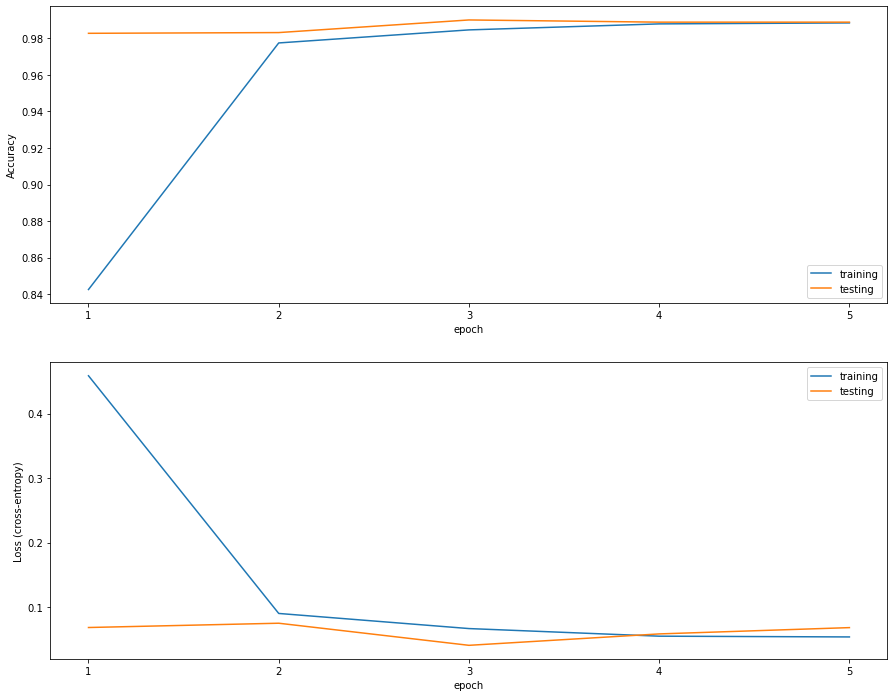

In [6]:
# REPORT: ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- #
AUG_STR = DATA_AUG if DATA_AUG else ""

# output report:
report.output_progress_plot(
    OUT_DIR         = OUT_DIR_E3,
    tag             = "VGG11_{}".format("_".join(AUG_STR)),
    verbose_level   = VERBOSE_LEVEL
)

# output model:
t.save(MODEL_DICT["VGG11"], "{}/last_{}.pt".format(OUT_DIR_E3, "_".join(AUG_STR)))

In [7]:
# Loading training dataset:
sample_x = None
sample_y = None

for X, y in test_dataset:
    sample_x = X
    sample_y = y
    break

# test
sample_x_dev = sample_x.to(device)
y_prediction_1 = MODEL_DICT["VGG11"](sample_x_dev).argmax(dim=1)

# report:
print("[{}]> \n> y:{} \n> y_pred:{}".format("test", sample_y.tolist(), y_prediction_1.tolist()))


[test]> 
> y:[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4, 1, 7, 6, 9] 
> y_pred:[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 8, 1, 7, 6, 9]


/home/jx/JXProject/Github/UW__4B_Individual_Works/CS 480/A5 Package/src_code/jx_lib.py:209: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(sqr,sqr,i+1)


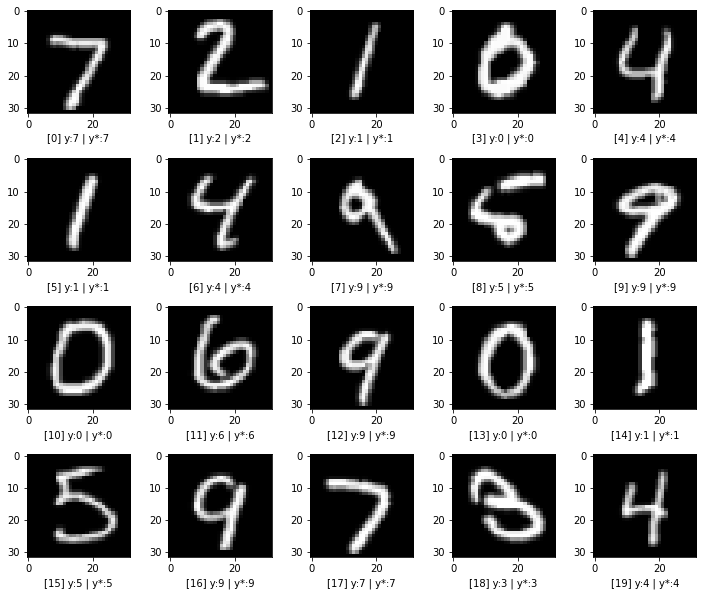

In [8]:
# Report samples
imgs = {}
for i in range(20):
    text = "[{}] y:{} | y*:{}".format(i, sample_y.tolist()[i], y_prediction_1.tolist()[i])
    imgs[text] = sample_x[i][0]
    
jx_lib.imgs_plot(dict_of_imgs=imgs, figsize=(10,10), OUT_DIR = OUT_DIR_E3, tag = "Sample Images", cmap="gray")

## E3 - Q2: FGSM
- See implementation of fgsm attack below:
- See resultant testing samples in the end.

### Results:
[e=0.10] > Original: [LOSS: -20.8493 | ACC: 0.9826] | FGSM-attack: [LOSS: -12.0806 | ACC: 0.6896] Ellapsed: 4.10 s 

[e=0.20] > Original: [LOSS: -20.8235 | ACC: 0.9824] | FGSM-attack: [LOSS: -8.8329 | ACC: 0.3972] Ellapsed: 4.08 s 

[e=0.50] > Original: [LOSS: -20.8055 | ACC: 0.9835] | FGSM-attack: [LOSS: -6.5080 | ACC: 0.2909] Ellapsed: 4.07 s 

### Comments
- As these adversarial images shown (in the end), as the epsilon increases, the image becomes much harder to recognize, and the overall accuracy drops dramatically.
- Invisible perturbation may completely changes the CNN VGG11 output as we may see at epsilon of 0.1, which drops to 69% from 98.3% prior the attack.
- CNNs’ decision boundary is constructed based on sparsely populated training samples in a high-dimension. Hence, it could be quite sensitive to these adversarial attacks.

In [9]:
def gen_adversarial_image( 
    image,
    epsilon,
    data_gradient
):
    sign_ = data_gradient.sign()
    preturbed_image = image + epsilon * sign_
    preturbed_image = t.clamp(preturbed_image, 0, 1) # clip [0,1]
    return preturbed_image

def fgsm_attack(
    model,
    x_dev,
    y_dev,
    device,
    epsilon,
    loss_func
) -> Dict:
    status_dict = {}
    
    # grad
    x_dev.requires_grad = True
    
    # raw image feed:
    y_output = model(x_dev)
    y_pred_initial = y_output.argmax(dim=1)
    
    # compute loss:
    loss = loss_func(y_output, y_dev)
    
    # reset:
    model.zero_grad()

    # compute backward gradients:
    loss.backward()
    
    # collect grad from hardware:
    data_grad = x_dev.grad.data
    
    # generate adversarial image (with fgsm attack):
    x_dev_perturbed = gen_adversarial_image(
        image = x_dev,
        epsilon = epsilon,
        data_gradient = data_grad
    )
    
    # re-compute the fgsm attacked image:
    y_output_perturbed = model(x_dev_perturbed)
    y_pred_perturbed = y_output_perturbed.argmax(dim=1)
    loss_perturbed = loss_func(y_output_perturbed, y_dev)
    
    # log:
    status_dict["loss"] = loss
    status_dict["loss_perturbed"] = loss_perturbed
    status_dict["y_pred_initial"] = y_pred_initial
    status_dict["y_pred_perturbed"] = y_pred_perturbed
    
    return status_dict, x_dev_perturbed
    
    
def perform_fgsm_attack(
    model,
    device,
    test_dataset,
    epsilon,
    loss_func,
    n_samples
):
    print("=== Performing FGSM Attack: ")
    test_loss_sum, test_acc_sum, test_n, test_start = 0.0, 0.0, 0, time.time()
    test_loss_sum_perturbed, test_acc_sum_perturbed = 0.0, 0.0
    
    img_samples = {}

    batch_count = 0
    for i, (X, y) in enumerate(test_dataset):
        print("   >[{}/{}]".format(i+1, len(test_dataset)),  end='\r')
        
        # device acc.
        x_dev, y_dev = X.to(device), y.to(device)
    
        # attack:
        status_dict, x_dev_perturbed = fgsm_attack(
            model = model,
            device = device,
            epsilon = epsilon,
            loss_func = loss_func,
            x_dev = x_dev,
            y_dev = y_dev,
        )
        
        # Compute Accuracy
        test_loss_sum += status_dict["loss"].item()
        test_acc_sum += (status_dict["y_pred_initial"] == y_dev).sum().item()
        test_loss_sum_perturbed += status_dict["loss_perturbed"].item()
        test_acc_sum_perturbed += (status_dict["y_pred_perturbed"] == y_dev).sum().item()
        test_n += y.shape[0]
        batch_count += 1

        # Sample Images Randomly:
        if len(img_samples) < n_samples and np.random.rand() > 0.5:
            sample_index = np.random.choice(range(len(y_dev.tolist())))
            label = "[{}] y*:{} | y*_attacked:{}".format(
                (len(img_samples)+1),
                status_dict["y_pred_initial"].tolist()[sample_index], 
                status_dict["y_pred_perturbed"].tolist()[sample_index]
            )
            img_samples[label] = x_dev_perturbed[sample_index][0].squeeze().detach().cpu().numpy()
            
    test_loss = test_loss_sum / batch_count
    test_acc = test_acc_sum / test_n

    fgsm_test_loss = test_loss_sum_perturbed / batch_count
    fgsm_test_acc = test_acc_sum_perturbed / test_n
    
    test_ellapse = time.time() - test_start
    
    return test_loss, test_acc, fgsm_test_loss, fgsm_test_acc, test_n, test_ellapse, img_samples

=== Performing FGSM Attack: 
[e=0.10] > Original: [LOSS: -16.6127 | ACC: 0.9879] | FGSM-attack: [LOSS: -9.9447 | ACC: 0.8027] Ellapsed: 4.13 s 
=== Performing FGSM Attack: 
[e=0.20] > Original: [LOSS: -16.5788 | ACC: 0.9886] | FGSM-attack: [LOSS: -6.0281 | ACC: 0.4275] Ellapsed: 4.11 s 
=== Performing FGSM Attack: 
[e=0.50] > Original: [LOSS: -16.5478 | ACC: 0.9884] | FGSM-attack: [LOSS: -3.4546 | ACC: 0.2688] Ellapsed: 4.12 s 


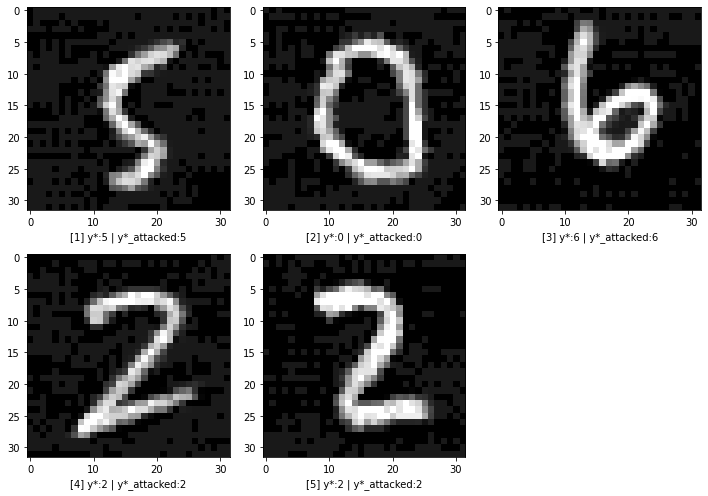

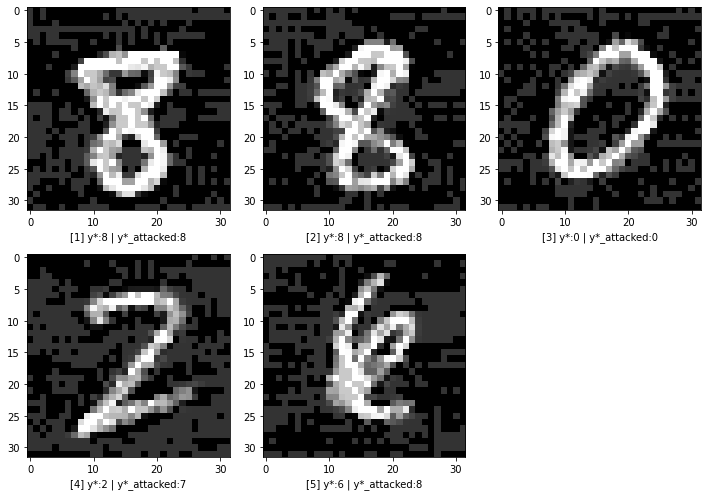

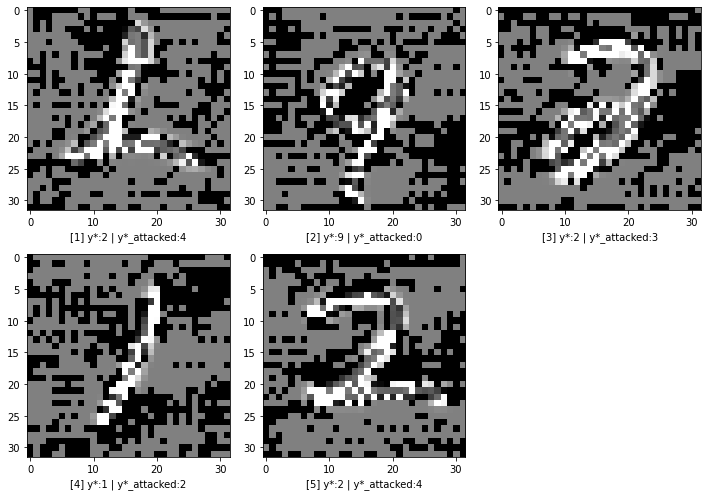

In [10]:
# Perform FGSM: --- ----- ----- ----- ----- ----- ----- ----- ----- #
for epsilon in [0.1, 0.2, 0.5]:
    test_loss, test_acc, fgsm_test_loss, fgsm_test_acc, test_n, test_ellapse, img_samples = perform_fgsm_attack(
        model = MODEL_DICT["VGG11"],
        device = device,
        test_dataset = test_dataset,
        epsilon = epsilon,
        # loss_func = CrossEntropyLoss(),
        loss_func = nll_loss, # Negative log likelihood loss
        n_samples = 5,
    )

    # report:
    print('[e={:.2f}] > Original: [LOSS: {:.4f} | ACC: {:.4f}] | FGSM-attack: [LOSS: {:.4f} | ACC: {:.4f}] Ellapsed: {:.2f} s '.format(
        epsilon, test_loss, test_acc, fgsm_test_loss, fgsm_test_acc, test_ellapse
    ))
    jx_lib.imgs_plot(
        dict_of_imgs=img_samples, figsize=(10,10), OUT_DIR = OUT_DIR_E3, 
        tag = "Sample Images [e={}]".format(epsilon), cmap="gray", show=True
    )
    

## E3 - Q3: Adversarial Training
- See results below:
- See implementation below (modified version based on 'jx_pytorch_lib'.

### Comments:
- As we may observed from the testdata results, and sampled output, we can see there is a dramatic improvements by incorporating the FGSM attack on training dataset. Here, an epsillon of 0.2 is used, and the epsillon of 0.5 FGSM attacks now can reach 94% performance in comparison to 29% in Ex3.2.

In [11]:
# FGSM training strategy
def train_with_fgsm_attack(
    device,
    train_dataset, 
    net, 
    optimizer, 
    loss_func,
    epsilon: float,
    max_data_samples: Optional[int] = None,
    verbose_level: jp.VerboseLevel = jp.VerboseLevel.LOW,
):
    # Training:
    if verbose_level >= jp.VerboseLevel.LOW:
        print("  >> Learning (wip)")
    train_loss_sum, train_acc_sum, train_n, train_start = 0.0, 0.0, 0, time.time()
    batch_count = 0
    for i, (X, y) in enumerate(train_dataset):
        if max_data_samples is not None:
            if i >= max_data_samples:
                break
            if verbose_level >= jp.VerboseLevel.HIGH:
                print("   >[{}/{}]".format(i, max_data_samples), end='\r')
        elif verbose_level >= jp.VerboseLevel.HIGH:
            print("   >[{}/{}]".format(i, len(train_dataset)),  end='\r')

        # hardware-acceleration
        if device != None:
            X = X.to(device)
            y = y.to(device)

        # > FGSM attack on training data:
        status_dict, x_dev_perturbed = fgsm_attack(
            model = net,
            device = device,
            epsilon = epsilon,
            loss_func = loss_func,
            x_dev = X,
            y_dev = y,
        )
        
        # Train with Perturbed Images:
        # Predict:
        y_prediction = net(x_dev_perturbed)
        # Calculate loss
        loss = loss_func(y_prediction, y)
        # Gradient descent > [ LEARNING ]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Compute Accuracy
        train_loss_sum += loss.item()
        train_acc_sum += (y_prediction.argmax(dim=1) == y).sum().item()
        train_n += y.shape[0]
        batch_count += 1

    train_loss = train_loss_sum / batch_count
    train_acc = train_acc_sum / train_n
    train_ellapse = time.time() - train_start

    return train_loss, train_acc, train_n, train_ellapse

def train_and_monitor_with_FGSM_attack(
    device,
    train_dataset, 
    test_dataset, 
    optimizer, 
    loss_func,
    net, 
    epsilon: float,
    num_epochs: int,
    # history_epoch_resolution: float = 1.0, TODO: mini-batches progress!!!
    max_data_samples: Optional[int] = None,
    verbose_level: jp.VerboseLevel = jp.VerboseLevel.LOW,
):
    report = jp.ProgressReport()
    # Cross entropy
    for epoch in range(num_epochs):
        if verbose_level >= jp.VerboseLevel.LOW:
            print("> epoch {}/{}:".format(epoch + 1, num_epochs))

        # Train:
        train_loss, train_acc, train_n, train_ellapse = train_with_fgsm_attack(
            device = device,
            train_dataset = train_dataset, 
            net = net, 
            optimizer = optimizer, 
            loss_func = loss_func,
            max_data_samples = max_data_samples,
            verbose_level = verbose_level,
            epsilon = epsilon,
        )

        # Testing:
        test_loss, test_acc, test_n, test_ellapse = jp.A4_EX1_CNN_HELPER.test(
            device = device,
            test_dataset = test_dataset, 
            net = net, 
            loss_func = loss_func,
            max_data_samples = max_data_samples,
            verbose_level = verbose_level
        )

        # Store
        report.append(
            epoch         = epoch + 1,
            train_loss    = train_loss,
            train_acc     = train_acc,
            train_time    = train_ellapse,
            test_loss     = test_loss,
            test_acc      = test_acc,
            test_time     = test_ellapse,
            learning_rate = optimizer.param_groups[0]["lr"],
            verbose       = (verbose_level >= jp.VerboseLevel.MEDIUM)
        )
    return report

In [12]:
# LOAD NET: ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- #
# check device:
# hardware-acceleration
device = None
if t.cuda.is_available():
    print("[ALERT] Attempt to use GPU => CUDA:0")
    device = t.device("cuda:0")
else:
    print("[ALERT] GPU not found, use CPU!")
    device =  t.device("cpu")
MODEL_DICT["VGG11-FGSM"].to(device)

[ALERT] Attempt to use GPU => CUDA:0


Sequential(
  (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Conv2d(256, 512, kernel_si

In [13]:
# TRAIN: ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- #
# train & evaulate:
report = train_and_monitor_with_FGSM_attack(
    device        = device,
    train_dataset = train_dataset, 
    test_dataset  = test_dataset,
    net           = MODEL_DICT["VGG11-FGSM"], 
    optimizer     = Adam(MODEL_DICT["VGG11-FGSM"].parameters(), lr=LEARNING_RATE), 
    num_epochs    = TOTA_NUM_EPOCHS,
    verbose_level = VERBOSE_LEVEL,
    max_data_samples = MAX_SAMPLES,
    # Let's use:
    loss_func = CrossEntropyLoss(),
    epsilon = 0.2,
)

> epoch 1/5:
  >> Learning (wip)
  >> Testing (wip)
    epoch 2 > Training: [LOSS: 2.3147 | ACC: 0.1107] | Testing: [LOSS: 2.3014 | ACC: 0.1135] Ellapsed: 46.41 s | rate:1.31416
> epoch 2/5:
  >> Learning (wip)
  >> Testing (wip)
    epoch 3 > Training: [LOSS: 2.3015 | ACC: 0.1124] | Testing: [LOSS: 2.3015 | ACC: 0.1135] Ellapsed: 46.45 s | rate:1.32957
> epoch 3/5:
  >> Learning (wip)
  >> Testing (wip)
    epoch 4 > Training: [LOSS: 2.3014 | ACC: 0.1124] | Testing: [LOSS: 2.3012 | ACC: 0.1135] Ellapsed: 46.46 s | rate:1.32234
> epoch 4/5:
  >> Learning (wip)
  >> Testing (wip)
    epoch 5 > Training: [LOSS: 2.3014 | ACC: 0.1123] | Testing: [LOSS: 2.3010 | ACC: 0.1135] Ellapsed: 46.49 s | rate:1.32892
> epoch 5/5:
  >> Learning (wip)
  >> Testing (wip)
    epoch 6 > Training: [LOSS: 2.3014 | ACC: 0.1124] | Testing: [LOSS: 2.3012 | ACC: 0.1135] Ellapsed: 46.51 s | rate:1.33543


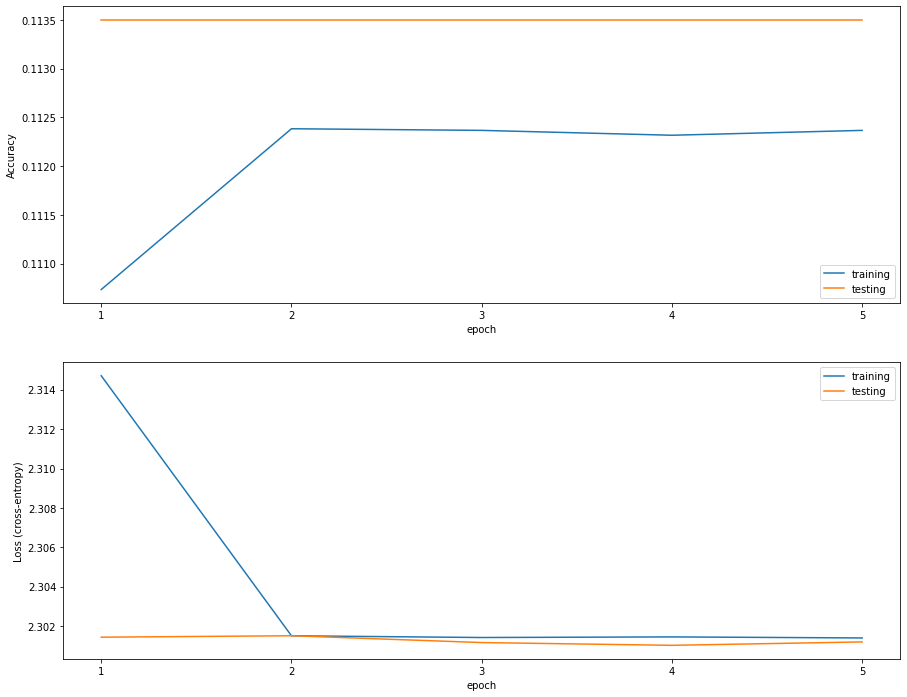

In [14]:
# REPORT: ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- #
AUG_STR = DATA_AUG if DATA_AUG else ""

# output report:
report.output_progress_plot(
    OUT_DIR         = OUT_DIR_E3,
    tag             = "VGG11-FGSM_{}".format("_".join(AUG_STR)),
    verbose_level   = VERBOSE_LEVEL
)

# output model:
t.save(MODEL_DICT["VGG11-FGSM"], "{}/last_fgsm_{}.pt".format(OUT_DIR_E3, "_".join(AUG_STR)))

=== Performing FGSM Attack: 
[e=0.10] > Original: [LOSS: -0.0025 | ACC: 0.1135] | FGSM-attack: [LOSS: -0.0024 | ACC: 0.1135] Ellapsed: 4.13 s 
=== Performing FGSM Attack: 
[e=0.20] > Original: [LOSS: -0.0025 | ACC: 0.1135] | FGSM-attack: [LOSS: -0.0025 | ACC: 0.1135] Ellapsed: 4.13 s 
=== Performing FGSM Attack: 
[e=0.50] > Original: [LOSS: -0.0024 | ACC: 0.1135] | FGSM-attack: [LOSS: -0.0025 | ACC: 0.1135] Ellapsed: 4.13 s 


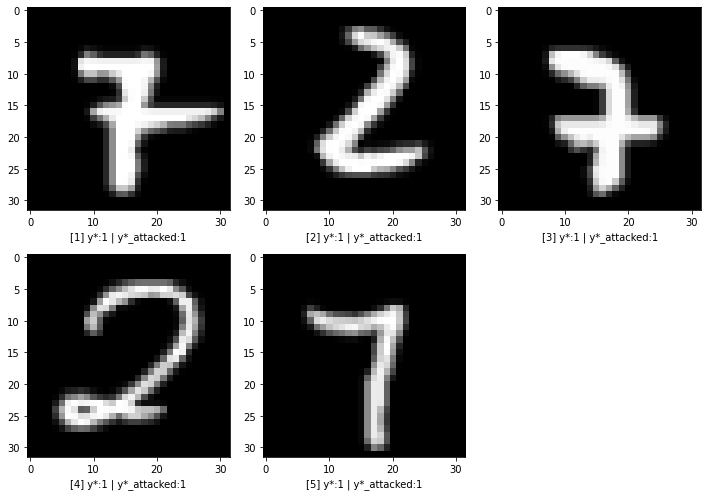

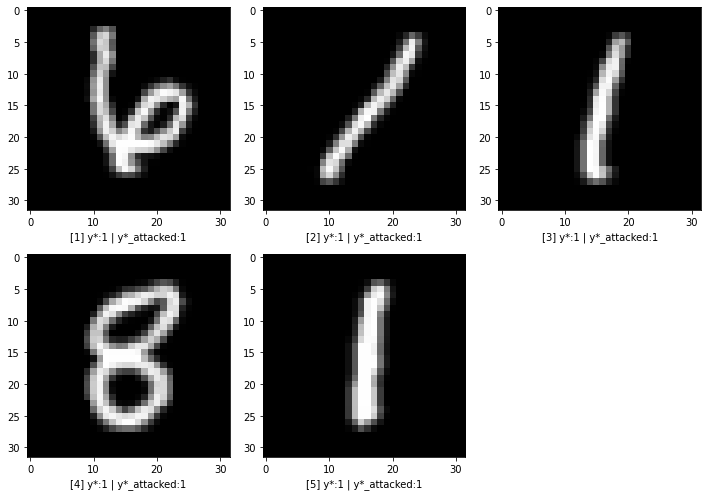

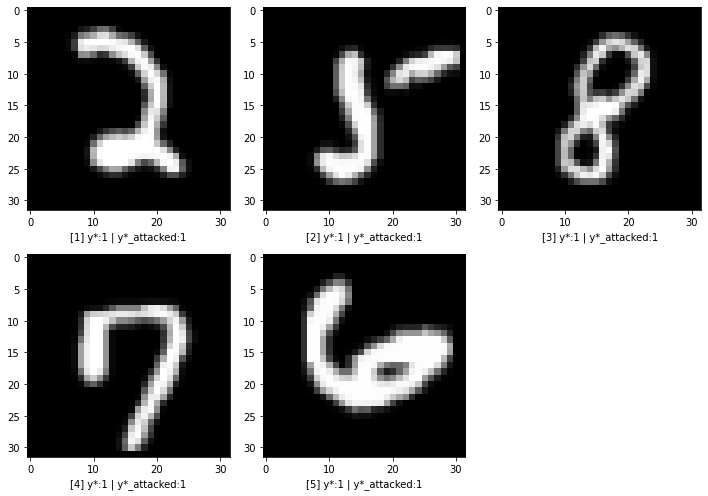

In [15]:
# Perform FGSM: --- ----- ----- ----- ----- ----- ----- ----- ----- #
for epsilon in [0.1, 0.2, 0.5]:
    test_loss, test_acc, fgsm_test_loss, fgsm_test_acc, test_n, test_ellapse, img_samples = perform_fgsm_attack(
        model = MODEL_DICT["VGG11-FGSM"],
        device = device,
        test_dataset = test_dataset,
        epsilon = epsilon,
        # loss_func = CrossEntropyLoss(),
        loss_func = nll_loss, # Negative log likelihood loss
        n_samples = 5,
    )

    # report:
    print('[e={:.2f}] > Original: [LOSS: {:.4f} | ACC: {:.4f}] | FGSM-attack: [LOSS: {:.4f} | ACC: {:.4f}] Ellapsed: {:.2f} s '.format(
        epsilon, test_loss, test_acc, fgsm_test_loss, fgsm_test_acc, test_ellapse
    ))
    jx_lib.imgs_plot(
        dict_of_imgs=img_samples, figsize=(10,10), OUT_DIR = OUT_DIR_E3, 
        tag = "Sample Images (VGG11-FGSM) [e={}]".format(epsilon), cmap="gray", show=True
    )
    

## (Bonus: ~3pts) E3 - Q4: More Robust Model
- CNNs’ decision boundary is constructed based on sparsely populated training samples (Nguyen et al., 2014) in a high-dimension. Adversarial examples used in this experiment are populated around the decision boundary, therefore, they are often indistinguishable from natural images if one uses point-wise prediction. 
- In the stochastic FF, uncertainty around the input pixel is propa- gated throughout every layer of CNNs and provides marginal information. Instead of point-wise prediction, integrating such information increases a chance to make correct prediction for adversar- ial examples. Adding stronger noise drags the adversarial examples farther apart from the correct decision region thereby lowering the accuracy.
- As a result, we may just simply dropout between each convolution layers, to introduce random noises to the system, hence correcting the decision by lowering the sensitivity.

In [16]:
MODEL_DICT["VGG11-ROBUST"] =  Sequential(
            ## CNN Feature Extraction
            Conv2d(  1,  64, 3, 1, 1), BatchNorm2d( 64), ReLU(), MaxPool2d(2,2),
            Dropout2d(p=0.5),
            Conv2d( 64, 128, 3, 1, 1), BatchNorm2d(128), ReLU(), MaxPool2d(2,2),
            Dropout2d(p=0.5),
            Conv2d(128, 256, 3, 1, 1), BatchNorm2d(256), ReLU(),
            Dropout2d(p=0.5),
            Conv2d(256, 256, 3, 1, 1), BatchNorm2d(256), ReLU(), MaxPool2d(2,2),
            Dropout2d(p=0.5),
            Conv2d(256, 512, 3, 1, 1), BatchNorm2d(512), ReLU(),
            Dropout2d(p=0.5),
            Conv2d(512, 512, 3, 1, 1), BatchNorm2d(512), ReLU(), MaxPool2d(2,2),
            Dropout2d(p=0.5),
            Conv2d(512, 512, 3, 1, 1), BatchNorm2d(512), ReLU(),
            Dropout2d(p=0.5),
            Conv2d(512, 512, 3, 1, 1), BatchNorm2d(512), ReLU(), MaxPool2d(2,2),
            # Classifier
            Flatten(1),
            Linear( 512, 4096), ReLU(), Dropout(0.5),
            Linear(4096, 4096), ReLU(), Dropout(0.5),
            Linear(4096,   10),
        )
# LOAD NET: ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- #
# check device:
# hardware-acceleration
device = None
if t.cuda.is_available():
    print("[ALERT] Attempt to use GPU => CUDA:0")
    device = t.device("cuda:0")
else:
    print("[ALERT] GPU not found, use CPU!")
    device =  t.device("cpu")
MODEL_DICT["VGG11-ROBUST"].to(device)

[ALERT] Attempt to use GPU => CUDA:0


Sequential(
  (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Dropout2d(p=0.5, inplace=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Dropout2d(p=0.5, inplace=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU()
  (13): Dropout2d(p=0.5, inplace=False)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (16): ReLU

In [17]:
# TRAIN: ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- #
# train & evaulate:
report = jp.A4_EX1_CNN_HELPER.train_and_monitor(
    device        = device,
    train_dataset = train_dataset, 
    test_dataset  = test_dataset,
    loss_func     = CrossEntropyLoss(),
    net           = MODEL_DICT["VGG11-ROBUST"], 
    optimizer     = Adam(MODEL_DICT["VGG11-ROBUST"].parameters(), lr=LEARNING_RATE), 
    num_epochs    = TOTA_NUM_EPOCHS,
    verbose_level = VERBOSE_LEVEL,
    max_data_samples = MAX_SAMPLES,
)


> epoch 1/5:
  >> Learning (wip)
  >> Testing (wip)
    epoch 2 > Training: [LOSS: 1.0377 | ACC: 0.6327] | Testing: [LOSS: 0.3128 | ACC: 0.9120] Ellapsed: 23.31 s | rate:1.35622
> epoch 2/5:
  >> Learning (wip)
  >> Testing (wip)
    epoch 3 > Training: [LOSS: 0.2410 | ACC: 0.9357] | Testing: [LOSS: 0.1640 | ACC: 0.9598] Ellapsed: 23.31 s | rate:1.35821
> epoch 3/5:
  >> Learning (wip)
  >> Testing (wip)
    epoch 4 > Training: [LOSS: 0.1606 | ACC: 0.9597] | Testing: [LOSS: 0.1450 | ACC: 0.9650] Ellapsed: 23.33 s | rate:1.33857
> epoch 4/5:
  >> Learning (wip)
  >> Testing (wip)
    epoch 5 > Training: [LOSS: 0.1321 | ACC: 0.9690] | Testing: [LOSS: 0.1120 | ACC: 0.9735] Ellapsed: 23.34 s | rate:1.35458
> epoch 5/5:
  >> Learning (wip)
  >> Testing (wip)
    epoch 6 > Training: [LOSS: 0.1185 | ACC: 0.9720] | Testing: [LOSS: 0.1326 | ACC: 0.9722] Ellapsed: 23.34 s | rate:1.35658


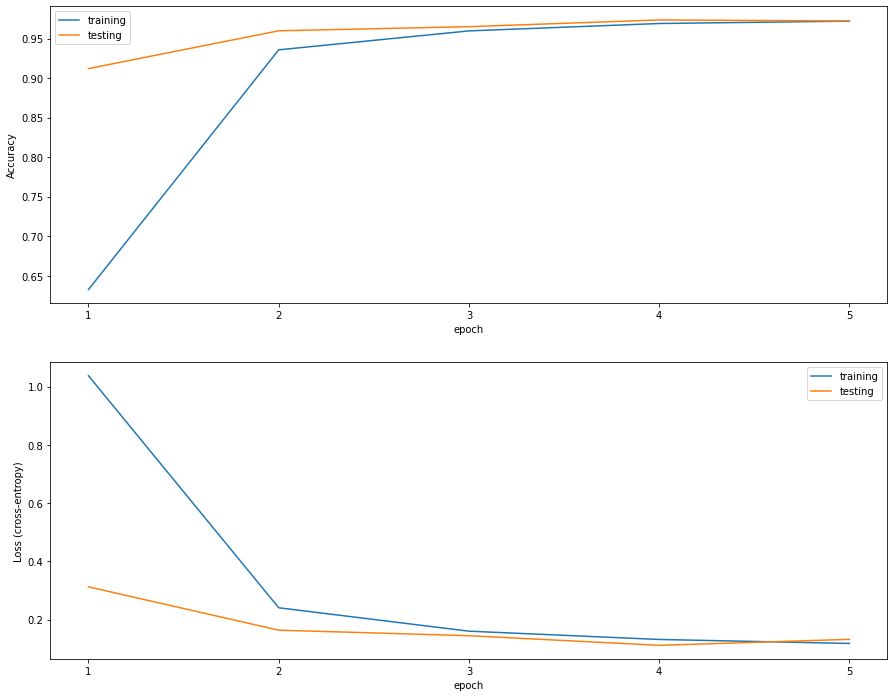

In [18]:
# REPORT: ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- #
AUG_STR = DATA_AUG if DATA_AUG else ""

# output report:
report.output_progress_plot(
    OUT_DIR         = OUT_DIR_E3,
    tag             = "VGG11-ROBUST_{}".format("_".join(AUG_STR)),
    verbose_level   = VERBOSE_LEVEL
)

# output model:
t.save(MODEL_DICT["VGG11-ROBUST"], "{}/last_robust_{}.pt".format(OUT_DIR_E3, "_".join(AUG_STR)))

### Comments:
- Recall the original VGG11 after the attack:

[e=0.10] > Original: [LOSS: -20.8493 | ACC: 0.9826] | FGSM-attack: [LOSS: -12.0806 | ACC: 0.6896] Ellapsed: 4.10 s 

[e=0.20] > Original: [LOSS: -20.8235 | ACC: 0.9824] | FGSM-attack: [LOSS: -8.8329 | ACC: 0.3972] Ellapsed: 4.08 s 

[e=0.50] > Original: [LOSS: -20.8055 | ACC: 0.9835] | FGSM-attack: [LOSS: -6.5080 | ACC: 0.2909] Ellapsed: 4.07 s 


- Now, lets attack the robust model trained with the same attack:

[e=0.10] > Original: [LOSS: -12.2066 | ACC: 0.9787] | FGSM-attack: [LOSS: -9.2008 | ACC: 0.8717] Ellapsed: 4.23 s 

[e=0.20] > Original: [LOSS: -12.1912 | ACC: 0.9786] | FGSM-attack: [LOSS: -6.2752 | ACC: 0.6440] Ellapsed: 4.20 s 

[e=0.50] > Original: [LOSS: -12.1313 | ACC: 0.9787] | FGSM-attack: [LOSS: -1.4502 | ACC: 0.2111] Ellapsed: 4.20 s 


- As, we may see, there is a significant improvements in terms of FGSM attack, although the model is trained with original dataset as VGG11.

=== Performing FGSM Attack: 
[e=0.10] > Original: [LOSS: -11.4605 | ACC: 0.9735] | FGSM-attack: [LOSS: -8.9375 | ACC: 0.8651] Ellapsed: 4.24 s 
=== Performing FGSM Attack: 
[e=0.20] > Original: [LOSS: -11.5644 | ACC: 0.9734] | FGSM-attack: [LOSS: -6.2442 | ACC: 0.6536] Ellapsed: 4.22 s 
=== Performing FGSM Attack: 
[e=0.50] > Original: [LOSS: -11.4851 | ACC: 0.9742] | FGSM-attack: [LOSS: -2.0096 | ACC: 0.2610] Ellapsed: 4.23 s 


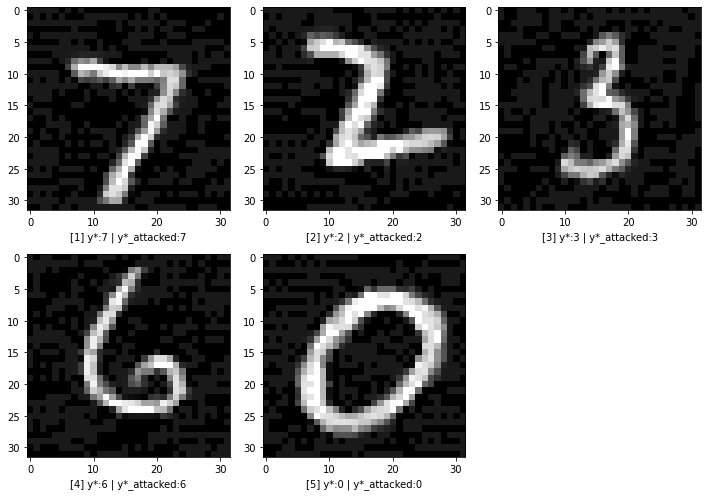

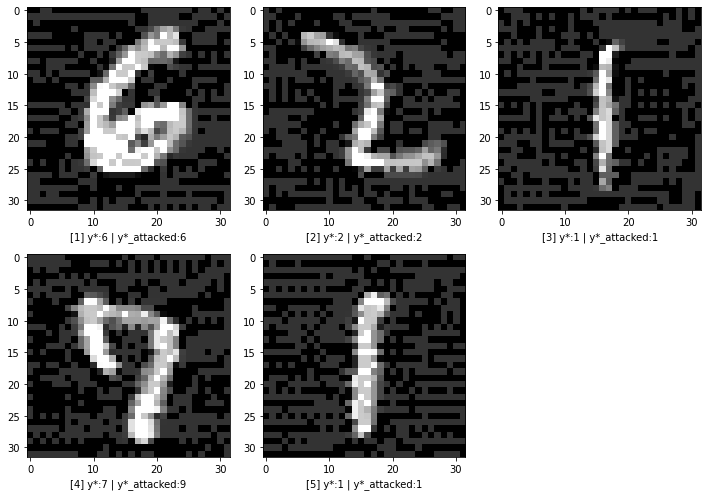

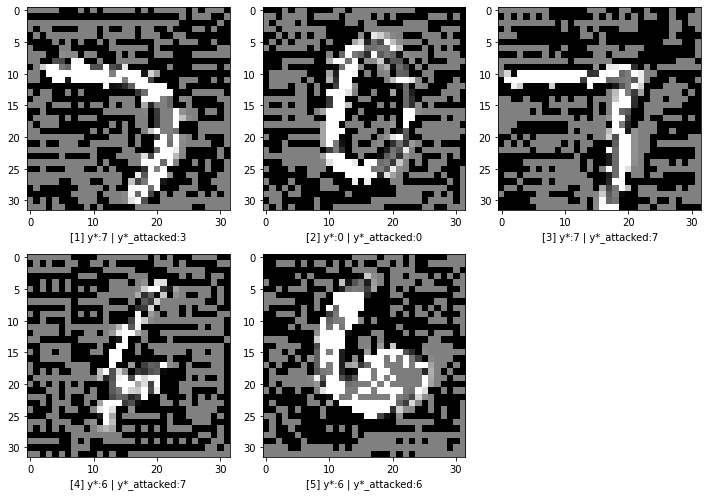

In [19]:
# Perform FGSM: --- ----- ----- ----- ----- ----- ----- ----- ----- #
for epsilon in [0.1, 0.2, 0.5]:
    test_loss, test_acc, fgsm_test_loss, fgsm_test_acc, test_n, test_ellapse, img_samples = perform_fgsm_attack(
        model = MODEL_DICT["VGG11-ROBUST"],
        device = device,
        test_dataset = test_dataset,
        epsilon = epsilon,
        # loss_func = CrossEntropyLoss(),
        loss_func = nll_loss, # Negative log likelihood loss
        n_samples = 5,
    )

    # report:
    print('[e={:.2f}] > Original: [LOSS: {:.4f} | ACC: {:.4f}] | FGSM-attack: [LOSS: {:.4f} | ACC: {:.4f}] Ellapsed: {:.2f} s '.format(
        epsilon, test_loss, test_acc, fgsm_test_loss, fgsm_test_acc, test_ellapse
    ))
    jx_lib.imgs_plot(
        dict_of_imgs=img_samples, figsize=(10,10), OUT_DIR = OUT_DIR_E3, 
        tag = "Sample Images (VGG11-ROBUST) [e={}]".format(epsilon), cmap="gray", show=True
    )
    